In [13]:
import sys
sys.path.append('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github')


In [14]:

# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
# import math
import numpy as np
import pandas as pd
import random
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df

!pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristic import NumericHeuristic5
from pct.tree.splitter.splitter import Splitter
from pct.tree.tree import Tree

In [15]:
data = pd.read_csv("/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/ml-1m/ratings.txt",sep='::',index_col=False,names=["user_id","item_id","rating","timestamp"],header=None,engine='python')
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
# Iteratively filters out users and items with fewer than the threshold number of interactions until no changes happen.
data = threshold_interactions_df(data,'user_id','item_id',100,100)
matrix,rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = df_to_matrix(data,"user_id","item_id","rating")

# split to train, X and eval sets
al,train,_ = train_test_split(matrix,1) # train_test_split(interactions, split_count, fraction=None)
# train: a matrix containing only the 1 held-out rating per user

# ml 1M
X_matrix,test,_ = train_test_split(al,30)
# test: a matrix containing only the 30 held-out ratings per user
# X: a matrix containing the rest of the ratings

Starting interactions info
Number of rows: 6040
Number of cols: 3706
Sparsity: 4.468%
Ending interactions info
Number of rows: 2828
Number of columns: 1919
Sparsity: 14.284%


In [32]:
def get_nodes_by_level(self, level):
    """
    Retrieve all nodes at a specific level with valid item IDs and their associated users.
    
    :param level: The depth level (0-indexed)
    :return: List of tuples (node, user_ids) where:
             - node.attribute_name is a valid integer item ID
             - user_ids is list of original user IDs in this node
    """
    if self.root is None:
        return []

    queue = [(self.root, 0)]
    valid_nodes = []

    while queue:
        node, current_level = queue.pop(0)

        if current_level == level:
            # Validation checks
            is_valid_item = isinstance(node.attribute_name, int)
            has_users = hasattr(node, 'user_ids') and len(node.user_ids) > 0
            is_internal_node = not node.is_leaf
            
            if all([is_valid_item, has_users, is_internal_node]):
                valid_nodes.append( (node, node.user_ids) )
                
        elif current_level < level:
            for child in node.children:
                if child is not None:
                    queue.append((child, current_level + 1))

    return valid_nodes


Original matrix
    ↓
    a matrix containing only the 1 held-out rating per user → train         (for initial model because we are simulating the "cold-start" or early-user scenario)
    Remaining → al
        ↓
        Split out 30 ratings → test    (for evaluation)
        Remaining → X_matrix           (for elicitation)


To explain the `get_nodes_by_level` function to someone who doesn't know coding, let’s break it down into simple concepts and analogies:

### Purpose of the Function
The function organizes all the nodes of a tree into groups based on their depth or level in the tree. Imagine a tree where each level represents a layer of branches, starting from the trunk (root) at level 0, then moving outward to higher levels. This function helps us collect all the nodes at each level into separate groups.

### Step-by-Step Explanation
1. **Start with the Root**:
   - Think of the root as the base of the tree (level 0). The function begins by focusing on this starting point.

2. **Create a Queue**:
   - Imagine you have a line (queue) of nodes waiting to be processed. The root node is added to this line first, along with its level (0).

3. **Process Each Node**:
   - The function takes one node at a time from the queue and checks which level it belongs to.
   - If this is the first time we’re seeing this level, we create a new group for it.

4. **Add Node to Its Group**:
   - Once we know which level the node belongs to, we add it to that group.

5. **Add Children to the Queue**:
   - Every node can have child nodes (branches growing out of it). The function adds these child nodes to the queue and assigns them to the next level (current level + 1).

6. **Repeat Until All Nodes Are Processed**:
   - The function keeps processing nodes from the queue until there are no more nodes left to process.

7. **Return Groups**:
   - At the end, we have a collection of groups where each group represents all the nodes at a specific level in the tree.




# Approach 1

In [ ]:
x_df = matrix_to_full_df(train, idx_to_rid, idx_to_cid)
pct = Tree(max_depth=7)
pct.fit(x_df, x_df)

In [6]:
pct.print_tree_structure()

Leaf Node: No
Depth: 0
Item_ID: 32
user_ids: [   0    1    2 ... 2825 2826 2827]
Total_Error: 1503.759138084138
Children:
    Leaf Node: Yes
    Depth: 1
user_ids: [ 230 1969]
    Leaf Node: Yes
    Depth: 1
user_ids: [ 161 1732 1414]
    Leaf Node: No
    Depth: 1
    Item_ID: 3471
user_ids: [   0    1    2 ... 2825 2826 2827]
    Total_Error: 1488.901995226995
    Children:
        Leaf Node: Yes
        Depth: 2
user_ids: [1061  813 1841  665]
        Leaf Node: Yes
        Depth: 2
user_ids: [1892  517  596]
        Leaf Node: No
        Depth: 2
        Item_ID: 296
user_ids: [   0    1    2 ... 2825 2826 2827]
        Total_Error: 1474.5547730047729
        Children:
            Leaf Node: No
            Depth: 3
            Item_ID: 1357
user_ids: [1670    6 2312  364 2286 2326 2621 2430]
            Total_Error: 1.875
            Children:
                Leaf Node: Yes
                Depth: 4
user_ids: []
                Leaf Node: Yes
                Depth: 4
user_ids: []
  

Let's say I want to achieve this:
For example, in the root (depth 0), we use item id 32 to split the tree and we obtain 3 nodes (A, B, C) at depth 1. I want to obtain a list that contains item id 32 from depth 0 and all the users at depth 1.

The code retrieves nodes at a single specified level:
- For depth 0: Returns only the root node (item ID 32).
- For depth 1: Returns all three child nodes (A, B, C) with their user_ids.


To get both the root’s item ID and the children’s user IDs, you need to call the function twice.

In [ ]:
# Extract item IDs (integers) from non-leaf nodes

nodes_at_level_1 = pct.get_nodes_by_level(0) # Returns list of nodes at level 1

item_ids = [
    node.attribute_name
    for node in nodes_at_level_1
    if isinstance(node.attribute_name, int)  # Ensure attribute_name is an integer
]

print("Item IDs at level 1:", item_ids)
# Convert item IDs to user IDs  



Item IDs at level 1: [32]


In [ ]:
# nodes_at_level = pct.get_nodes_by_level(1)

parent_node = pct.get_nodes_by_level(3)  # Root node (depth 0)
child_nodes = pct.get_nodes_by_level(4)    # Nodes A, B, C (depth 1)

print(f"Item ID: {parent_node[2].item_id}")
for child in child_nodes:
    print(f"Child User IDs: {child.user_ids}")


    
    

In [36]:
def test_tree_levels(pct, iteration=8):
    """Test node extraction at each tree level."""
    for current_depth in range(iteration):
        nodes_at_level = pct.get_nodes_by_level(current_depth)
        # Track valid split nodes
        item_user_map = {}
        
        for node in nodes_at_level:
            if node.is_leaf or not isinstance(node.attribute_name, int):
                continue
                
            # Collect child users
            child_users = []
            for i, child in enumerate(node.children):
                if child:
                    child_users.extend(child.user_ids)
                else:
                    print(f"  Child {i}: None")
            
            item_user_map[node.attribute_name] = child_users
            # print (f"Item ID: {node.attribute_name}, Child User IDs: {child_users}")
            # print the whole item_user_map of all levels
        print(f"Level {current_depth} item_user_map: {item_user_map}")

            



test_tree_levels(pct, iteration=8)


Level 0 item_user_map: {32: [230, 1969, 161, 1732, 1414, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211

In [52]:
def elicitation_tree(train, test, X, iteration=8, rid_to_idx=None, cid_to_idx=None):
    rmse, mae = [], []
    
    # Initial training setup
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    all_users = range(train.shape[0])
    
    # 1. Train the tree once with initial data
    # pct = Tree(max_depth=iteration-1)
    # pct.fit(train_copy, u_data['rating'])  # Assuming u_data contains target ratings
    
    # Initial model training
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    algo = SVD().fit(data_r.build_full_trainset())
    
    # Evaluate initial performance
    # test_r = Dataset.load_from_df(matrix_to_df_2(test, idx_to_rid, idx_to_cid), reader)
    # Evaluate initial performance
    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_set = list(zip(test_df['user_id'], test_df['item_id'], test_df['rating']))
    predictions = algo.test(test_set)

    # predictions = algo.test(test_r.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    print(f"Initial RMSE: {rmse[-1]}, Initial MAE: {mae[-1]}")

    # Main elicitation loop using pre-built tree
    for current_depth in range(0, iteration):
        print(f"🚀 Processing depth {current_depth}")
        
        # 2. Get split items and their affected users from pre-built tree
        item_user_map = {}
        parent_nodes = pct.get_nodes_by_level(current_depth)
        
        for node in parent_nodes:
            if node.is_leaf or not isinstance(node.attribute_name, int):
                continue
                
            item_id = node.attribute_name
            item_idx = cid_to_idx[item_id] # Convert to matrix index
            child_users = []
            
            # Collect users from all children (like/hate/unknown groups)
            for child in node.children:
                if child and hasattr(child, 'user_ids') and child.user_ids.size > 0:
                    # Before conversion
                    # print(f"User ID type: {type(child.user_ids[0])}")
                    # print(f"rid_to_idx key type: {type(list(rid_to_idx.keys())[0])}")
                    user_indices = [rid_to_idx[int(u)] for u in child.user_ids if int(u) in rid_to_idx]
                    # print(f"Converted type: {type(int(child.user_ids[0]))}")
                    child_users.extend(user_indices)
            
            item_user_map[item_idx] = child_users
            print(f"Level {current_depth} item_user_map: {item_user_map}")
            # print length of users
            print(f"Item ID: {item_id}, Child User IDs: {child_users}, Length: {len(child_users)}")



        # 3. Update training data with revealed ratings
        for item_idx, users in item_user_map.items():
            for user_idx in users:
                train_copy[user_idx, item_idx] = X[user_idx, item_idx] # revealed rating from X 
                X_copy[user_idx, item_idx] = 0

        # 4. Retrain and evaluate (only the SVD model, tree remains fixed)
        updated_train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(updated_train_df[['user_id', 'item_id', 'rating']], reader)
        algo = SVD().fit(data_r.build_full_trainset())

        # test_r = Dataset.load_from_df(matrix_to_df_2(test, idx_to_rid, idx_to_cid), reader)
    # Evaluate initial performance
        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_set = list(zip(test_df['user_id'], test_df['item_id'], test_df['rating']))
        predictions = algo.test(test_set)
        
    
        
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))

    return rmse, mae


In [53]:
approach1 = elicitation_tree(train, test, X_matrix, iteration=8, rid_to_idx=rid_to_idx, cid_to_idx=cid_to_idx)
approach1_rmse = approach1[0]
approach1_mae = approach1[1]
print("Approach 1 RMSE:", approach1_rmse)
# print("Approach 1 MAE:", approach1_mae)
# Plotting the results


RMSE: 1.1619
MAE:  0.9678
Initial RMSE: 1.1618875451397128, Initial MAE: 0.9677747990051003
🚀 Processing depth 0
Level 0 item_user_map: {268: [97, 899, 65, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 19

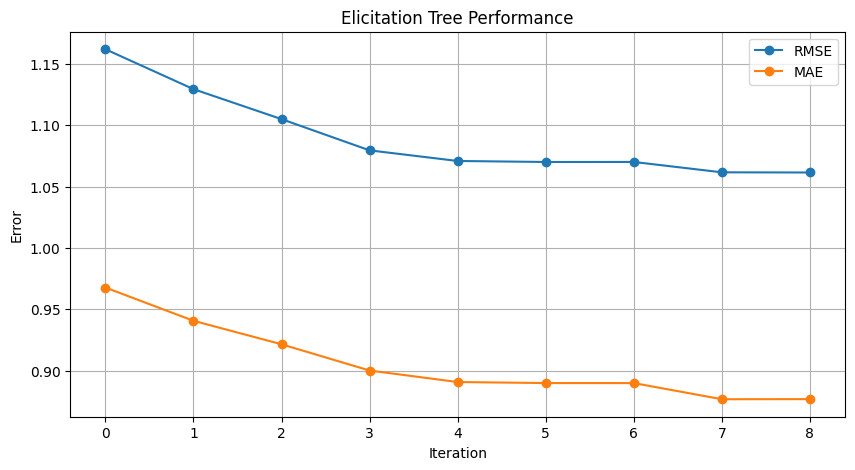

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(approach1_rmse)), approach1_rmse, label='RMSE', marker='o')
plt.plot(range(len(approach1_mae)), approach1_mae, label='MAE', marker='o')
plt.title('Elicitation Tree Performance')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()